# What is the Best Neighborhood in Pittsburgh?
### *Team Fam, LLC*
## Introduction:
Using data from WPRDC, we aimed to find the best nieghborhood in Pittsburgh. Since everyone's definition of "bestness" may be different, we decided to approach this from the angle of raising a family. So, what makes a neighborhood family friendly? As a parent or guardian, one would want to raise their children in an environment that promotes development and learning through a strong school system, safety and quietness through a low crime rate, and social and physical well-being through local entertainment facilities. Ultimately, this all boils down to three main ideas:
*Education, Safety, and Entertainment*.
## The Metric
In order to measure these attributes, we used the following data:
- [School Enrollment](https://data.wprdc.org/dataset/pittsburgh-american-community-survey-2015-school-enrollment/resource/eb1f8714-e0eb-4614-acfe-dfe0ebab942f)
- [Non-Traffic Citations](https://data.wprdc.org/dataset/non-traffic-citations/resource/6b11e87d-1216-463d-bbd3-37460e539d86?view_id=868aea6a-f85a-4547-8402-80c639555f13)
- [Playground Equipment](https://data.wprdc.org/dataset/playground-equipment/resource/e39ef76e-0a11-47c8-a86f-a37f55db7a2b)

School enrollment data allowed us to see the percentage of the community enrolled in school (pre-college), non-traffic citations gave us information on the amount of crime in the area, and playground equipment data provided a number of different playground equipments/facilities available in each neighborhood. Since each dataset includes different amounts of neighborhoods, we decided to use an arbitrary set of neighborhoods using those included in the dataset with the lowest amount of neighborhoods (playground equipments). While this ended up excluding some neighborhoods that would otherwise be considered in the top scores, we felt that it would only be fair if the neighborhoods up for consideration were given a score based on each dataset. By implementing a simple scoring system that assigned values to each neighborhood based on their position in sorted data **(the lowest score wins)**, we were able to show promising results that helped us determine the best neighborhood in Pittsburgh to raise a family. 

In [1]:
## Here, we import all of the necessary add-ons.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gp
import collections

## We establish our arbitary set of neighborhoods and create a new dataset used for calculating scores. 
ListOfNeighborhoods = pd.read_csv("playgroundEquipments.csv")
neighborhoods = ListOfNeighborhoods[["neighborhood"]].copy()
scores = neighborhoods.groupby("neighborhood").count()
scores["Score"] = 0

## School Enrollment:
The school enrollment data from WPRDC included those enrolled in nursery school through graduate school. Since Pittsburgh houses a high volume of college students, we decided that this part of the data would skew the result. So, we revised the dataset to only take into account those enrolled in grade 12 and under. To do this, we subtracted the number of people enrolled in college and graduate/professional school from the total and total enrolled and removed this data from the dataset. This allowed us to study the demographic of people still being "raised" by their parents or guardians. We then found the percentage of people enrolled in school by dividing the total enrolled by the total. This data is displayed on a table as well as a bar graph, showing the top ten neighborhoods in Pittsburgh to raise a family based on school enrollment.

In [2]:
# Import raw dataset
enrollment_data_raw = pd.read_csv("Enrollment-Data.csv")
# Pull columns needed for operations
enrollment_data_edit = enrollment_data_raw[["Neighborhood","Estimate; Total:","Estimate; Enrolled in school:",\
                                            "Estimate; Enrolled in school: - Enrolled in college, undergraduate years",\
                                            "Estimate; Enrolled in school: - Graduate or professional school"]].copy()

# Editing the columns so the total and total enrolled does not include college students
enrollment_data_edit["Enrolled In College"] = enrollment_data_raw["Estimate; Enrolled in school: - Enrolled in college, undergraduate years"] + enrollment_data_raw["Estimate; Enrolled in school: - Graduate or professional school"]
enrollment_data_edit["Total"] = enrollment_data_edit["Estimate; Total:"] - enrollment_data_edit["Enrolled In College"]
enrollment_data_edit["Total Enrolled"] = enrollment_data_edit["Estimate; Enrolled in school:"] - enrollment_data_edit["Enrolled In College"]

# Creating a final data set with only the data needed and adding a column with the percentage enrolled
enrollment_data = enrollment_data_edit[["Neighborhood","Total","Total Enrolled"]].copy()
enrollment_data["Percentage Enrolled In School"] = (enrollment_data["Total Enrolled"] / enrollment_data["Total"])*100
enrollment_data = enrollment_data[["Neighborhood", "Percentage Enrolled In School"]]

## Dropping the neighborhoods that are not included in the arbitrar
for item in enrollment_data["Neighborhood"]:
    if len(scores[scores.index == item]):
        continue
    else:
        enrollment_data = enrollment_data[enrollment_data.Neighborhood != item]
        
#Sorting the values by percentage and displaying the data
enrollment_data.sort_values(by = "Percentage Enrolled In School", ascending = False, inplace = True)
enrollment_data.reset_index(inplace = True, drop = True)
enrollment_data

Neighborhood  Percentage Enrolled In School
0      Homewood North                      35.496737
1           Allentown                      33.003016
2             Elliott                      31.046312
3   Bedford Dwellings                      25.509372
4             Bon Air                      25.263158
..                ...                            ...
62        Polish Hill                       5.411955
63     Strip District                       3.656821
64    Central Oakland                       3.556658
65              Bluff                       3.197674
66           West End                       0.000000

[67 rows x 2 columns]

Text(0, 0.5, 'Neighborhood')

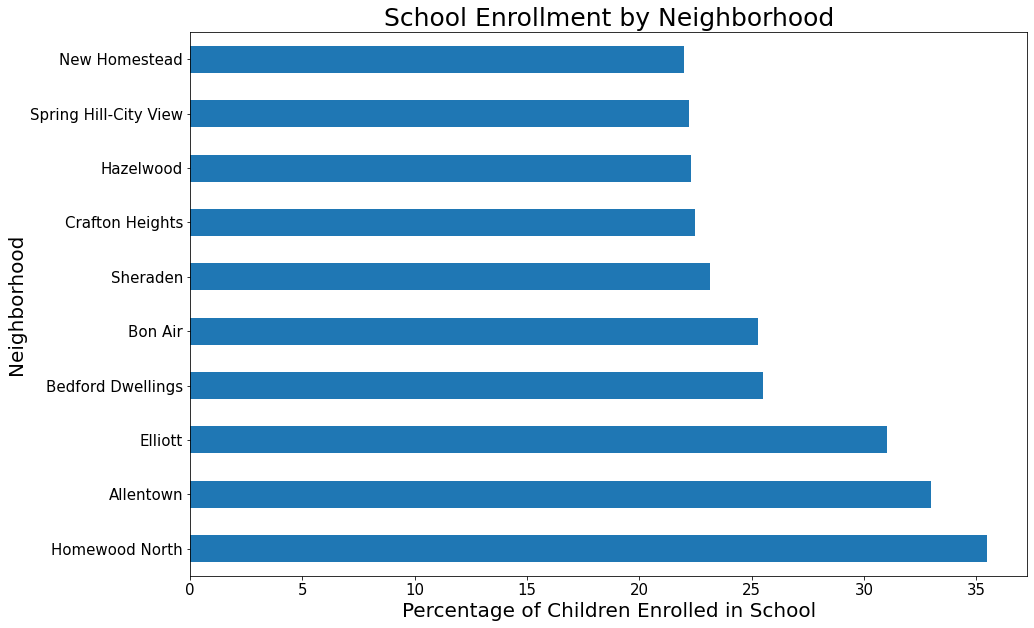

In [3]:
# Plotting the data on a bar graph
enrollment_graph = enrollment_data.head(10).plot.barh(x = "Neighborhood",figsize = (15,10), legend = None, fontsize = 15)
enrollment_graph.set_title("School Enrollment by Neighborhood", fontsize = 25)
enrollment_graph.set_xlabel("Percentage of Children Enrolled in School", fontsize = 20)
enrollment_graph.set_ylabel("Neighborhood", fontsize = 20)

#### Conclusion: School Enrollment
As the top ten neighborhoods in the sorted data shows, **Homewood North** comes in with an enrollment rate of nearly 35.5 percent. Using our metric, this makes it the best neighborhood to raise a family based on school enrollment. However, neighborhoods like Central Oakland, West End, and Bluff have very low enrollment rates.  This means there are few children in the area attending school, so if a family wants their children to be around others of a similar age and grade, they may want to avoid this neighborhoods. 

In [4]:
score = 1 ## A counter variable used to choose how much to add to each score

## Traverses through the list of neighborhoods
## If the item is first/best, a score of 1 is added.
## If the percentage of people enrolled in a neighborhood is less than that of the previous in the list, one is added to the score counter and the amount for score is added to the neighborhood's score.
## If the percentage of people enrolled in a neighborhood is equal to that of the previous, the same score is added.
        
for item in enrollment_data["Neighborhood"]:
    index = enrollment_data.index.get_loc(enrollment_data.index[enrollment_data["Neighborhood"] == item][0])
    if index == 0:
        scores.at[item, "Score"] += score
    elif enrollment_data.loc[index, "Percentage Enrolled In School"] < enrollment_data.loc[index-1, "Percentage Enrolled In School"]:
        score += 1
        scores.at[item, "Score"] += score
    elif enrollment_data.loc[index, "Percentage Enrolled In School"] == enrollment_data.loc[index-1, "Percentage Enrolled In School"]:
        scores.at[item, "Score"] += score

scores.sort_values(by = "Score", inplace = True)
scores.head(10)

Score
neighborhood                   
Homewood North                1
Allentown                     2
Elliott                       3
Bedford Dwellings             4
Bon Air                       5
Sheraden                      6
Crafton Heights               7
Hazelwood                     8
Spring Hill-City View         9
New Homestead                10
Perry South                  11
Windgap                      12
Fineview                     13
Garfield                     14
Larimer                      15
Lincoln-Lemington-Belmar     16
Squirrel Hill North          17
Regent Square                18
Carrick                      19
Highland Park                20

## Safety - Non-Traffic Citations:
The overall safeness and tranquility of a neighborhood is another important aspect to consider. We decided to gauge this by looking at the amount of non-traffic citations reported in each neighborhood in Pittsburgh. These kinds of citations are also known as "summary offenses" and are categorized as low-level criminal offenses. Examples include disorderly conduct, public drunkness, harassment, property damage, and trespassing. Not only is it dangerous, but these types of events can be disruptful to daily living, and as such, places with lower numbers would be concluded to be a better neighborhood to raise a family in terms of safety.

In [5]:
ntc = pd.read_csv("Non-Traffic-Citations.csv",
                  index_col="NEIGHBORHOOD") # read in dataset
ntc.head(5)

PK       CCR GENDER RACE   AGE            CITEDTIME  \
NEIGHBORHOOD                                                                    
North Oakland        1078081  16157849      M    B  29.0  2016-08-22T23:45:00   
North Oakland        1078082  16157849      M    W  21.0  2016-08-22T23:45:00   
Allegheny Center     1078083  16159579    NaN  NaN   NaN  2016-08-25T11:10:00   
Homewood South       1078084  16159780      M    B  22.0  2016-08-25T16:42:00   
Upper Lawrenceville  1078085  16161591      F    W  22.0  2016-08-28T00:58:00   

                                             INCIDENTLOCATION  \
NEIGHBORHOOD                                                    
North Oakland        200 Block N DITHRIDGE ST PITTSBURGH, PA    
North Oakland        200 Block N DITHRIDGE ST PITTSBURGH, PA    
Allegheny Center                   NORTH PARK PITTSBURGH, PA    
Homewood South       7200 Block FRANKSTOWN AV PITTSBURGH, PA    
Upper Lawrenceville      6100 Block BERLIN WY PITTSBURGH, PA    

                                                              OFFENSES ZONE  \
NEIGHBORHOOD                                                                  
North Oakland        5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...    4   
North Oakland        5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...    4   
Allegheny Center                               5505 Public Drunkenness    1   
Homewood South       6501(a)(1) Scattering Rubbish; Any waste, dang...    5   
Upper Lawrenceville  5503(a)(2) DISORDERLY CONDUCT - UNREASONABLE N...    2   

                    INCIDENTTRACT  COUNCIL_DISTRICT  PUBLIC_WORKS_DIVISION  \
NEIGHBORHOOD                                                                 
North Oakland                 507               8.0                    3.0   
North Oakland                 507               8.0                    3.0   
Allegheny Center             2204               NaN                    NaN   
Homewood South               1303               9.0                    2.0   
Upper Lawrenceville          1011               7.0                    2.0   

                             X          Y  
NEIGHBORHOOD                               
North Oakland       -79.951692  40.449311  
North Oakland       -79.951692  40.449311  
Allegheny Center      0.000000   0.000000  
Homewood South      -79.896254  40.457329  
Upper Lawrenceville -79.946664  40.485403

This dataset included a lot of information on the details of each citation, but we wanted to focus on the level of crime by the amount per neighborhood, so the table was altered to group the data by neighborhoods and display the total number of offenses each of them recorded. This was then sorted from the least number of citations to the greatest.

In [6]:
ntc_nbhd = ntc.groupby("NEIGHBORHOOD")[["OFFENSES"]]
ntc_nbhd = ntc_nbhd.count() # counting total number of offenses for each neighborhood

## Drops neighborhoods that are not included in the arbitrary set of neighborhoods
for item in ntc_nbhd.index:
    if len(scores[scores.index == item]):
        continue
    else:
        ntc_nbhd = ntc_nbhd.drop(item)
        
ntc_nbhd = ntc_nbhd.sort_values(by=["OFFENSES"], ascending=True) # sorting by number of offenses 
ntc_nbhd.head(10)

The entirety of the dataset was then plotted as a bar graph. From it, we can see that many neighborhoods have few citations, while South Side Flats and Central Oakland have reported the most.

<AxesSubplot:title={'center':'Number of Non-Traffic Citations in Pittsburgh Neighborhoods'}, xlabel='Number of Non-Traffic Citations', ylabel='Neighborhood'>

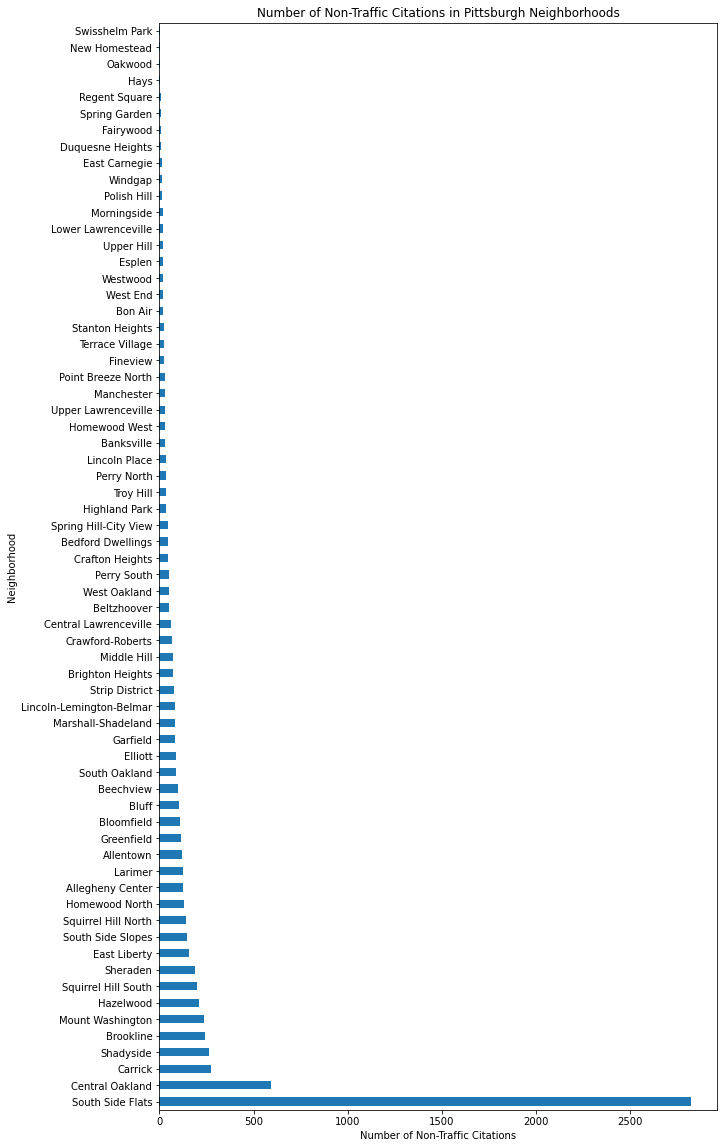

In [7]:
graph = ntc_nbhd.sort_values(by=["OFFENSES"], ascending=False)
graph = graph.plot.barh(y="OFFENSES",figsize=(10,20), legend=None) # plotting bar graph
graph.set_xlabel("Number of Non-Traffic Citations") # making labels for the graph
graph.set_ylabel("Neighborhood")
graph.set_title("Number of Non-Traffic Citations in Pittsburgh Neighborhoods")
graph # displays graph

Since there are so many neighborhoods, it is a little difficult to read. Thus, graphing only the top ten neighborhoods makes the process easier. We can tell the Mt. Oliver Boro, Ridgemont, and Chartiers City are some of the neighborhoods with the least amount of recorded offenses.

Text(0.5, 1.0, 'Number of Non-Traffic Citations in Pittsburgh Neighborhoods')

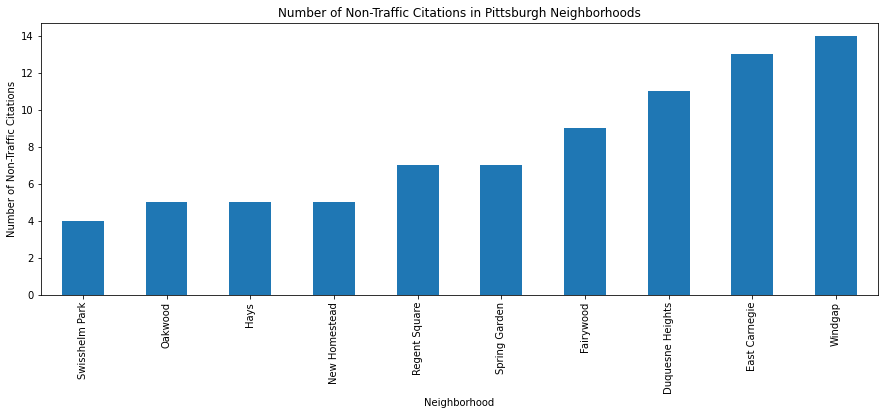

In [8]:
# graph of just the top 10 neighborhoods with least number of non-traffic citations
topten = ntc_nbhd[:10].plot(kind="bar", figsize=(15,5),legend=None)
topten.set_ylabel("Number of Non-Traffic Citations")
topten.set_xlabel("Neighborhood")
topten.set_title("Number of Non-Traffic Citations in Pittsburgh Neighborhoods")

We can visualize the data on a map as well. Seen below, areas with lower number of non-traffic citations are colored a light purple. As the amount increases, so does the intensity of the color. It also changes to the shade of blue. Hence, South Side Flats and Central Business District demonstrate significantly greater numbers since they are a much darker blue compared to the others. Also note that the light grey colors indicate neighborhoods with no data.

<AxesSubplot:>

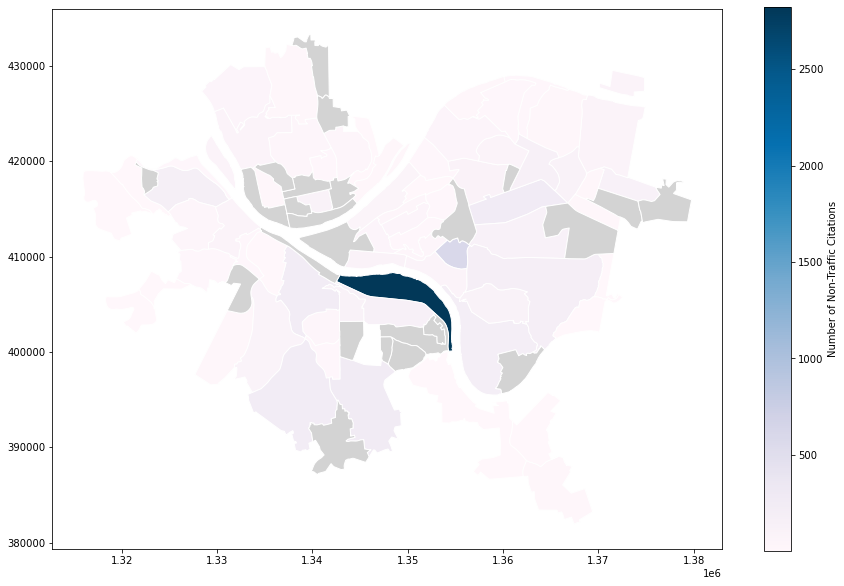

In [9]:
neighborhoods = gp.read_file("Neighborhoods/Neighborhoods_.shp") # read in shapefile
ntc_map = neighborhoods.merge(ntc_nbhd, how='left', left_on='hood', right_on='NEIGHBORHOOD') # merge
ntc_map.plot(column='OFFENSES', # data to be used for coloring
               cmap='PuBu',              # color palette
               edgecolor="white",        
               legend=True,              
               legend_kwds={'label': "Number of Non-Traffic Citations"}, 
               figsize=(15, 10),        
               missing_kwds={"color": "lightgrey"} # neighborhoods with no data are grey
               )

**Conclusion: Safety - Non-Traffic Citations**

From this dataset, we can conclude that Swisshelm Park, Oakwood, Hayes, and New Homestead are among the best neighborhoods to raise a family in. They reported the lowest number of low-level criminal offenses, indicating that not only are they safer areas to live in, where families do not have to worry as much about these kinds of incidents occurring, but also that life is more likely to be peaceful and quiet. The same cannot be said for neighborhoods like South Side Flats and Central Oakland, however, as they reflected much higher numbers of non-traffic citations.

In [10]:
ntc_nbhd.reset_index(inplace = True, drop = False)

score = 1 ## A counter variable used to choose how much to add to each score

## Traverses through the list of neighborhoods
## If the item is first/best, a score of 1 is added.
## If the number of offenses in a neighborhood is greater than that of the previous in the list, one is added to the score counter and the amount for score is added to the neighborhood's score.
## If the number of offenses in a neighborhood is equal to that of the previous, the same score is added.

for item in ntc_nbhd["NEIGHBORHOOD"]:
    if len(scores[scores.index == item]):
        index = ntc_nbhd.index.get_loc(ntc_nbhd.index[ntc_nbhd["NEIGHBORHOOD"] == item][0])
        if index == 0:
            scores.at[item, "Score"] += 1
        elif ntc_nbhd.loc[index, "OFFENSES"] > ntc_nbhd.loc[index-1, "OFFENSES"]:
            score += 1
            scores.at[item, "Score"] += score
        elif ntc_nbhd.loc[index, "OFFENSES"] == ntc_nbhd.loc[index-1, "OFFENSES"]:
            scores.at[item, "Score"] += score

## Sorts the scores and prints the current top 10
scores.sort_values(by = "Score", inplace = True)
scores.head(10)

Score
neighborhood                
New Homestead             12
Bon Air                   17
Windgap                   19
Regent Square             21
Bedford Dwellings         26
Fineview                  28
Crafton Heights           29
Spring Hill-City View     30
Swisshelm Park            31
Central Northside         32

## Playgrounds Equipments:

One other factor that we're taking into account when determining the "best" neighborhood in Pittsburgh is the number of playground equipments/facilities available in each neighborhood. According to our definition of "bestness", I thought that a neighborhood with the most number of playground equipments would be the best for raising a family. Playgrounds proide the perfect off-the-screen entertainment and offers various physical and social benefits for children as they go outdoors to play and have fun with eachtoher like playing tag or going on the swings. 

Instead of focusing on soley the number of playgrounds in each neighborhood, I thought that analyzing from the angle of the variety and amount of playground equipments would be more helpful. The more variety of playground equipments, the more things for children to enjoy and play with. This also means more opporunities for children to have fun without getting easily bored. 

In [11]:
#Load playground equipments data from the downloaded csv file from WPRDC

playground = pd.read_csv("playgroundEquipments.csv")
playground.head(10)

id                          name     equipment_type  manufacturer  \
0  1780722587          Able Long Playground   Play Area 2 to 5  Little Tykes   
1   702514290         North Ave. Playground   Play Area 2 to 5     Playworld   
2  1267038491  Vietnam Veteran's Playground              Slide  Little Tykes   
3    14898932  Schenley Overlook Playground       Swing 2 Bays  Little Tykes   
4   204832406  Schenley Overlook Playground              Slide  Little Tykes   
5   788191865          Chartiers Playground       Swing 2 Bays  Little Tykes   
6  1387089430          Chartiers Playground       Swing 2 Bays  Little Tykes   
7  1838217886          Chartiers Playground   Play Area 2 to 5  Little Tykes   
8  1315630398          Chartiers Playground  Play Area 5 to 12  Little Tykes   
9  1603952265          Chartiers Playground              Whirl           NaN   

  safety_surface_type ada_accessible  street_number             street  \
0       Pour in Place              f          211.0          Coast Ave   
1         SofSurfaces              f          377.0        W North Ave   
2         SofSurfaces              f          108.0  Panther Hollow Rd   
3         SofSurfaces              t            NaN        Overlook Dr   
4         SofSurfaces              f            NaN        Overlook Dr   
5         SofSurfaces              f         1550.0      Summerdale St   
6         SofSurfaces              t         3783.0      Chartiers Ave   
7         SofSurfaces              f         3789.0      Chartiers Ave   
8         SofSurfaces              f         1544.0      Summerdale St   
9         SofSurfaces              f         1548.0      Summerdale St   

          neighborhood  council_district  ward        tract  \
0            Beechview                 4    19  42003192000   
1     Allegheny Center                 1    22  42003562700   
2  Squirrel Hill South                 5    14  42003980500   
3  Squirrel Hill South                 5    14  42003980500   
4  Squirrel Hill South                 5    14  42003980500   
5              Windgap                 2    28  42003563000   
6              Windgap                 2    28  42003563000   
7              Windgap                 2    28  42003563000   
8              Windgap                 2    28  42003563000   
9              Windgap                 2    28  42003563000   

   public_works_division  pli_division  police_zone fire_zone   latitude  \
0                      5            19            6      4-28  40.408381   
1                      1            22            1       1-7  40.454526   
2                      3            14            4       2-8  40.434185   
3                      3            14            4       2-8  40.432130   
4                      3            14            4       2-8  40.432215   
5                      5            28            6      1-16  40.456812   
6                      5            28            6      1-16  40.457218   
7                      5            28            6      1-16  40.457329   
8                      5            28            6      1-16  40.456681   
9                      5            28            6      1-16  40.456970   

   longitude  
0 -80.028520  
1 -80.010188  
2 -79.944323  
3 -79.947774  
4 -79.947817  
5 -80.075131  
6 -80.075070  
7 -80.075145  
8 -80.075019  
9 -80.075110

For this dataset, we're mainly concerned with the third column (equipment_type) and the ninth column (neighborhood). 
The elements in equipment_type represent the different kinds of playground equipments available in each neighborhood, including slides, whirls, swings, play areas, and others.

In [12]:
#counted up each of the neighbohood and how much equipment they had
playground.groupby("neighborhood").count()

id  name  equipment_type  manufacturer  \
neighborhood                                                  
Allegheny Center     15    15              15            13   
Allentown             4     4               4             4   
Banksville            6     6               6             6   
Bedford Dwellings     3     3               3             3   
Beechview            21    21              21            21   
...                  ..   ...             ...           ...   
Upper Lawrenceville   5     5               5             4   
West End              3     3               3             3   
West Oakland          1     1               1             1   
Westwood              2     2               2             2   
Windgap               5     5               5             4   

                     safety_surface_type  ada_accessible  street_number  \
neighborhood                                                              
Allegheny Center                      15              15             15   
Allentown                              4               4              4   
Banksville                             6               6              0   
Bedford Dwellings                      3               3              3   
Beechview                             14              21             16   
...                                  ...             ...            ...   
Upper Lawrenceville                    4               5              2   
West End                               3               3              3   
West Oakland                           1               1              1   
Westwood                               2               2              0   
Windgap                                5               5              5   

                     street  council_district  ward  tract  \
neighborhood                                                 
Allegheny Center         15                15    15     15   
Allentown                 4                 4     4      4   
Banksville                0                 6     6      6   
Bedford Dwellings         3                 3     3      3   
Beechview                21                21    21     21   
...                     ...               ...   ...    ...   
Upper Lawrenceville       5                 5     5      5   
West End                  3                 3     3      3   
West Oakland              1                 1     1      1   
Westwood                  2                 2     2      2   
Windgap                   5                 5     5      5   

                     public_works_division  pli_division  police_zone  \
neighborhood                                                            
Allegheny Center                        15            15           15   
Allentown                                4             4            4   
Banksville                               6             6            6   
Bedford Dwellings                        3             3            3   
Beechview                               21            21           21   
...                                    ...           ...          ...   
Upper Lawrenceville                      5             5            5   
West End                                 3             3            3   
West Oakland                             1             1            1   
Westwood                                 2             2            2   
Windgap                                  5             5            5   

                     fire_zone  latitude  longitude  
neighborhood                                         
Allegheny Center            15        15         15  
Allentown                    4         4          4  
Banksville                   6         6          6  
Bedford Dwellings            3         3          3  
Beechview                   21        21         21  
...                        ...       ...        ...  
Upper Lawrenceville          5      

The code above displays a dataset that has counted up each of the 67 different neighborhoods (in alphabetical order) and the amount of playground equipments each neighborhood have (using the equipment_type column). 

In [13]:
#create a new dataframe called "counts" to count for the number of playground equipments within each  neighborhood.  
counts = playground["neighborhood"].value_counts().rename_axis('Neighborhood').reset_index(name='Number of Playground Equipments')
counts.head(67)

Neighborhood  Number of Playground Equipments
0   Squirrel Hill South                               32
1          East Liberty                               26
2             Beechview                               21
3      Allegheny Center                               15
4     South Side Slopes                               14
..                  ...                              ...
62             Westwood                                2
63  Lower Lawrenceville                                2
64               Esplen                                2
65         West Oakland                                1
66       Strip District                                1

[67 rows x 2 columns]

In the table above, I removed all of the other columns, aside from "neighborhood" and "equipment_type", that were not necessary for my evaluation. I renamed the "equipment_type" column to "Number of Playground Equipment" to show the counted values of all the different equipments for each of the 67 neighborhood. 

Text(0, 0.5, 'Neighborhood')

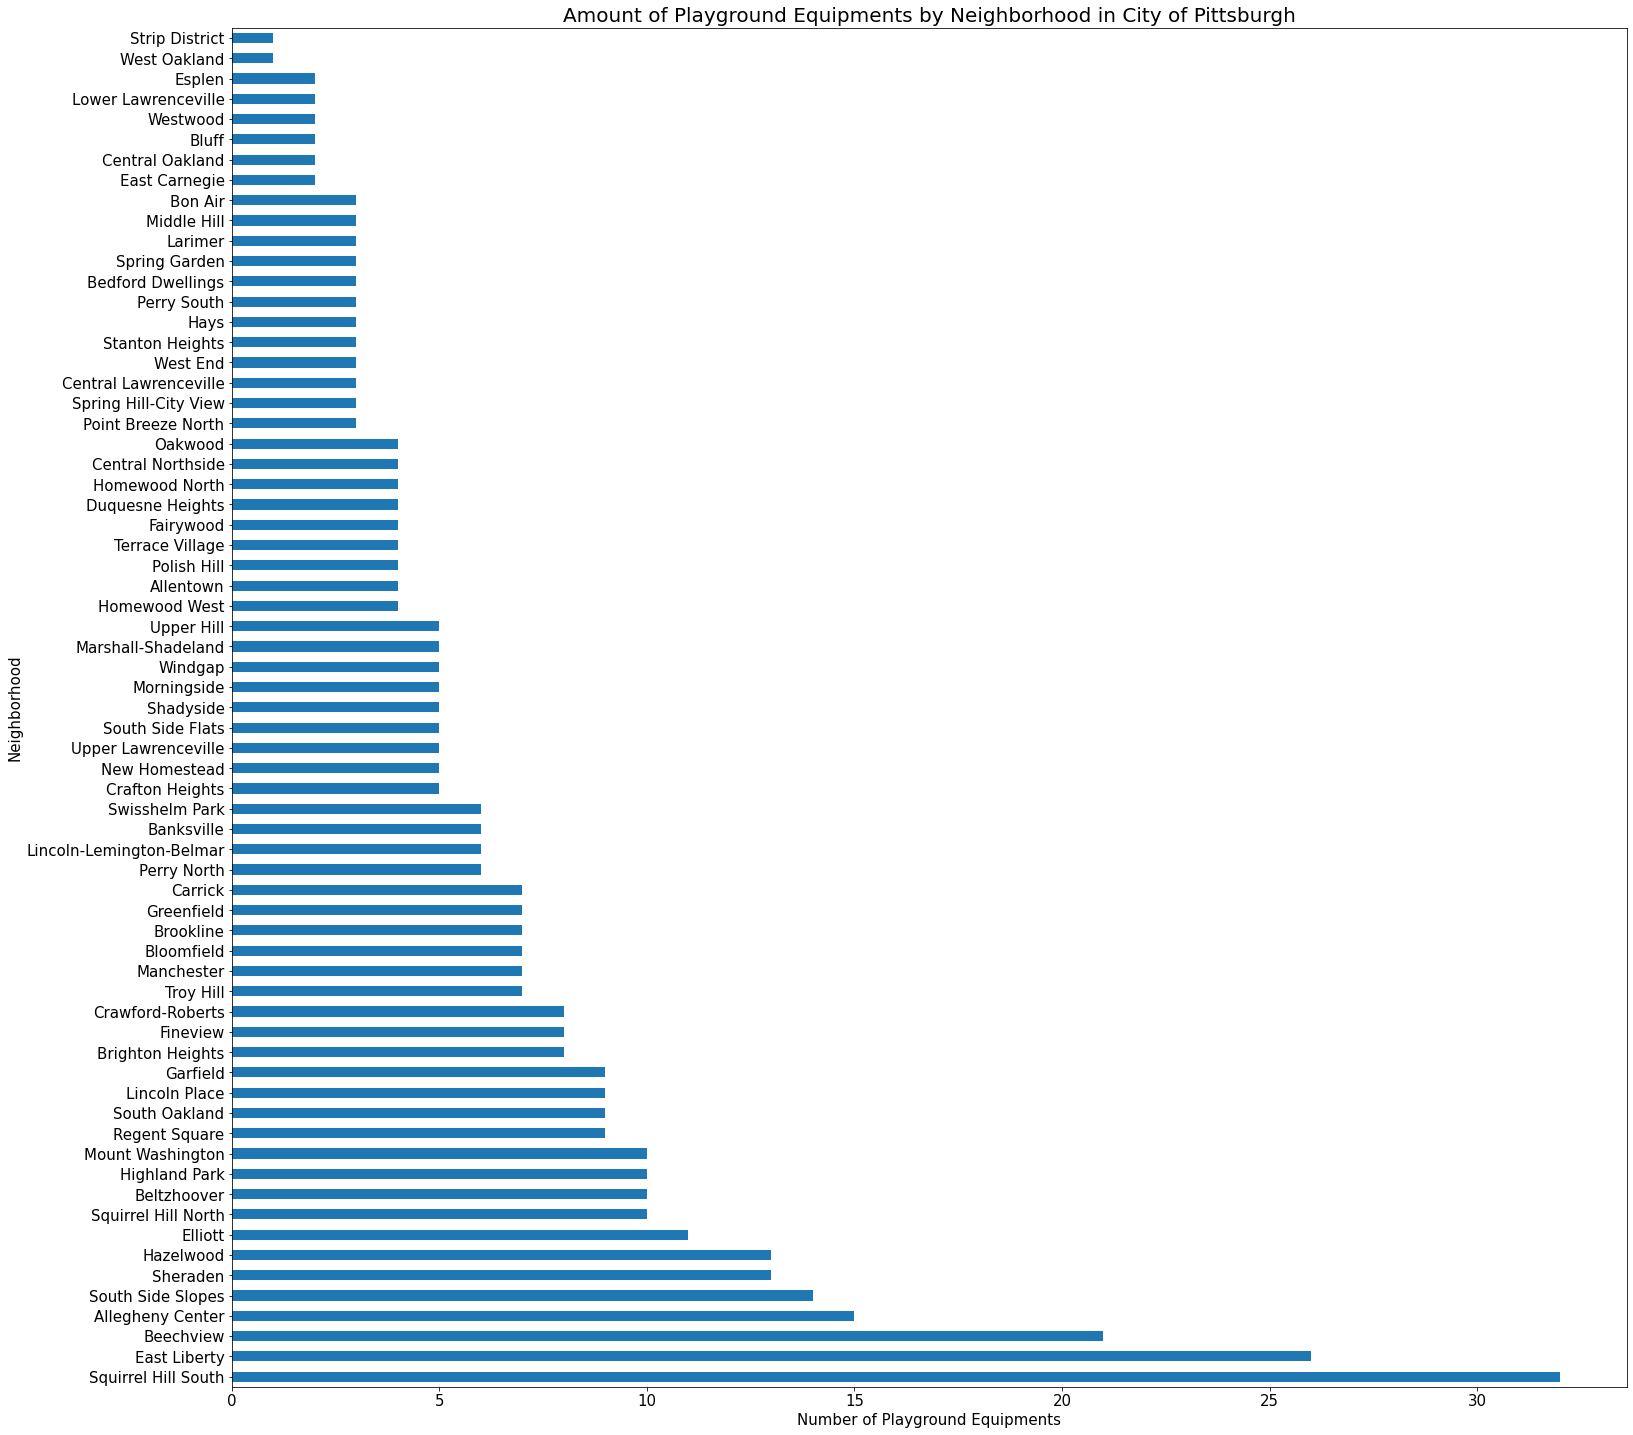

In [14]:
playground_graph = playground["neighborhood"].value_counts().plot.barh(x = "Neighborhood", width = 0.5, figsize=(25,25), legend = None, fontsize = 15)
playground_graph.set_title("Amount of Playground Equipments by Neighborhood in City of Pittsburgh", fontsize = 20)
playground_graph.set_xlabel("Number of Playground Equipments", fontsize = 15)
playground_graph.set_ylabel("Neighborhood", fontsize = 15)


**The Top 10**

In [15]:
#sort and label the top 10 neighborhoods with the most playground equipments. 
counts = playground["neighborhood"].value_counts().rename_axis('Neighborhood').reset_index(name='Number of Playground Equipments')
counts.head(10)

Neighborhood  Number of Playground Equipments
0  Squirrel Hill South                               32
1         East Liberty                               26
2            Beechview                               21
3     Allegheny Center                               15
4    South Side Slopes                               14
5             Sheraden                               13
6            Hazelwood                               13
7              Elliott                               11
8  Squirrel Hill North                               10
9          Beltzhoover                               10

In the above table, the top 10 neighborhoods (out of the 67 from the dataset) with the highest numbers of playground equipments are shown in descending order. 

Text(0, 0.5, 'Neighborhood')

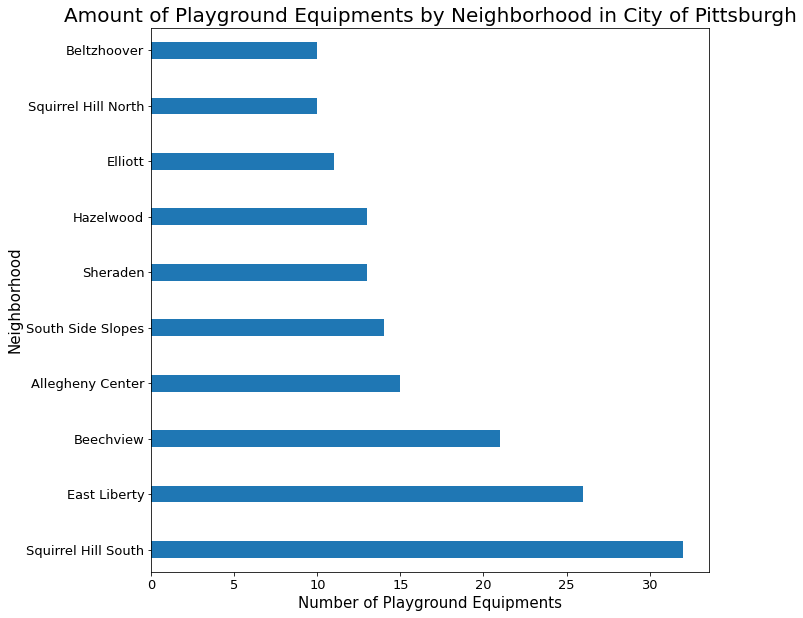

In [16]:
#plotting this data on a bar graph 
playground_graph = playground["neighborhood"].value_counts().head(10).plot.barh(x = "Neighborhood", width = 0.3, figsize=(10,10), legend = None, fontsize = 13)
playground_graph.set_title("Amount of Playground Equipments by Neighborhood in City of Pittsburgh", fontsize = 20)
playground_graph.set_xlabel("Number of Playground Equipments", fontsize = 15)
playground_graph.set_ylabel("Neighborhood", fontsize = 15)


The bar graph above is a visual representation for the chart shown. 
It shows the top 10 neighborhoods with the most playground equipments in increasing order from top to bottom. 

**Conclusion - Playground Equipments**

As you can see from both the chart and the bar graph, it is clear that **Squirrel Hill South** is the **"best"** Pittsburgh neighborhood for the **Playground Equipment metric** because it has the highest number of playground equipments (32) out of the 67 neighborhoods from the dataset, with East Libery and Beechview coming in 2nd and 3rd place respectively. Squirrel Hill South would be the "best" neighborhood for raising a family, because it has the most and a wide variety of playground equipments that any child can enjoy when playing outside. 


On the flipside, using this metric for our definition of "bestness", **West Oakland** the **Strip District** would be the **"worst"** neighborhoods for raising a family, because they each only have 1 piece of playground equipment. 

In [17]:
score = 1 ## A counter variable used to choose how much to add to each score

## Traverses through the list of neighborhoods
## If the item is first/best, a score of 1 is added.
## If the number of playground equipments in a neighborhood is less than that of the previous in the list, one is added to the score counter and the amount for score is added to the neighborhood's score.
## If the number of playground equipments in a neighborhood is equal to that of the previous, the same score is added.

for item in counts["Neighborhood"]:
    if len(scores[scores.index == item]):
        index = counts.index.get_loc(counts.index[counts["Neighborhood"] == item][0])
        if index == 0:
            scores.at[item, "Score"] += score
        elif counts.loc[index, "Number of Playground Equipments"] < counts.loc[index-1, "Number of Playground Equipments"]:
            score +=1
            scores.at[item, "Score"] += score
        elif counts.loc[index, "Number of Playground Equipments"] == counts.loc[index-1, "Number of Playground Equipments"]:
            scores.at[item, "Score"] += score

## Sorts the final scores
scores.sort_values(by = "Score", inplace = True)
scores.head(10)

Score
neighborhood                
New Homestead             25
Regent Square             30
Bon Air                   32
Windgap                   32
Fineview                  38
Bedford Dwellings         41
Crafton Heights           42
Elliott                   42
Swisshelm Park            43
Spring Hill-City View     45

## Conclusion
Since each dataset had a varying amount of neighborhoods, we selected the one with the least amount (playground equipments) and used that as our arbitrary list of neighborhoods. If a dataset included neighborhoods not in this list, they were not considered when calculating the lowest value (best) in our scoring system. However, the top ten neighborhoods in each dataset showed varying results, so the final "best" neighborhood was not as we expected since some of the neighborhoods were skipped. According to the final calculations, the top three neighborhoods were **New Homestead**, **Regent Square**, and **Bon Air** respectively. By our definition of "bestness", **New Homestead** is the best neighborhood to raise a family in. 